# Weekly COVID-19 Cases Dashboard Update
Center for Human Dynamics in the Mobile Age (HDMA) at San Diego State University

Jessica Embury

### MODULES

In [24]:
#import modules
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayerCollection
from arcgis.features import FeatureLayer

from copy import deepcopy
import json
import numpy as np
import os
import pandas as pd
import requests
import sys
import webbrowser

#ignore pandas slice warning
pd.options.mode.chained_assignment = None  # default='warn'

### CONFIRM USER VARIABLES BEFORE RUNNING CELLS

In [27]:
###########################
###SET DATA THROUGH DATE###
###########################
most_recent_date = '07/13/2021'  # Change date to the data through date using 'MM/DD/YYYY' format


##########################
###SET PATHS IN AND OUT###
##########################
#PATHS IN
#additional needed zip info - community name and population
zips_info_path = './data/zip_coords_pop.csv'

#PATHS OUT
#wide df with a column for each date
wide_df_path = './data/covid_accumulated_formatted.csv'

#path out for dash updates, feature layer overwrite
path_out= './data/covid_percents_upload.csv'
path_out2 = '../covid_data/percents/covid_percents_{}.csv'

#path to csv used to append new column to feature layer 2 for cumulative cases dashboard
append_csv_path = './data/sd_zip_cumulative_covid_append.csv'

#upload to dropbox
dropbox_cumulative = 'C:/Users/jesse/Dropbox/Mapping-Vulearable-Pop-Tasks/SD-County-Data/COVID-Data-Share-at-HDMA-Center/SD_Zipcode_COVID_{}.csv'

# 7 day dash layer overwrite
seven_path = './data/sandiego_covid_upload_7day.csv'

################################
###ARCGIS DETAILS FOR UPDATES###
################################

#feature layer IDs to overwrite
feature_layer2 = '2a2645b5f569461d916122c3e16d96f3'
seven_layer = 'f6558646808b4b88ba1d77e984b9f7e8'

#csv to append to feature_layer2
append_csv = '49be034d6b7a406ca291cb44e94e1be1'

#map IDs for symbology update
#confirmed cases map
cc = "763a114f5f114139af5517ac4c785bd8"

# seven day maps
seven_map = 'cd2e0028e1f049e7bd268d06c26cfe22'
seven_map_mobile = 'ee46036487c3491caf69209d2a67940c'

#urls for dashboards (to verify)
cumulative_dash = 'https://arcg.is/1zXq1m'
cumulative_mobile = 'https://arcg.is/1WLnjG'
seven_dash = 'https://experience.arcgis.com/experience/a630917e020440ba9a598bf1c32b7a74'

## SAVE SD COUNTY COVID-19 PDF FILES TO DROPBOX

In [3]:
#specify directory for new folder
pdf_path = 'C:/Users/jesse/Dropbox/Mapping-Vulearable-Pop-Tasks/SD-County-Data/{}'.format(most_recent_date.replace('/', '-'))

#create folder if it doesn't exist
if not os.path.exists(pdf_path):
    os.makedirs(pdf_path)

#base url for pdfs
url = 'https://www.sandiegocounty.gov/content/dam/sdc/hhsa/programs/phs/Epidemiology/'

#pdf names
pdfs = ['COVID-19%20Percentage%20Positive.pdf', 'COVID-19%20Cases%20by%20Date%20of%20Illness%20Onset.pdf', 
        'COVID-19%20Daily%20Update_City%20of%20Residence.pdf', 'COVID-19%20City%20of%20Residence_MAP.pdf', 
        'COVID-19%20Race%20and%20Ethnicity%20Summary.pdf', 'COVID-19%20Summary%20of%20Cases%20by%20Zip%20Code.pdf', 
        'COVID-19%20Hospitalizations%20by%20Date%20Admitted.pdf', 'COVID-19%20Hospitalizations%20Summary_ALL.pdf', 
        'COVID-19%20Deaths%20by%20Date%20of%20Death.pdf', 'COVID-19%20Deaths%20by%20Demographics.pdf', 
        'COVID-19_Daily_Status_Update.pdf', 'COVID-19%20Watch.pdf', 'Summary_County_of_San_Diego_Supported_Tests_by_Race_Ethnicity.pdf',
        'Summary_of_All_Tests_Reported_by_Race_Ethnicity.pdf', 'Summary_of_All_Tests_Reported_by_Zip_Code_of_Residence.pdf', 
        'Summary_Tests_Among_San_Diego_County_Residents_by_Race_Ethnicity.pdf', 'COVID19%20HHSA%20Region%20Dashboard.pdf', 
        'COVID19%20NORTH%20COASTAL%20Dashboard.pdf', 'COVID19%20NORTH%20INLAND%20Dashboard.pdf', 'COVID19%20NORTH%20CENTRAL%20Dashboard.pdf', 
        'COVID19%20CENTRAL%20Dashboard.pdf', 'COVID19%20EAST%20Dashboard.pdf', 'COVID19%20SOUTH%20Dashboard.pdf', 
        'COVID-19%20Vaccinations%20Demographics.pdf', 'COVID-19%20Vaccine%20Report%20by%20Zipcode.pdf',
        'Summary_Public_Health_Rooms_by_Race_Ethnicity.pdf', 'COSD_Case_Investigators_by_Race_Ethnicity.pdf', 'COSD_Contact_Tracers_by_Race_Ethnicity.pdf',
        'COVID-19%20Variant%20Case%20Summary.pdf', 'COVID-19%20Homeless%20Summary.pdf', 'COVID-19%20Vaccinations%20by%20Health%20Equity%20Zip%20Codes.pdf',
        'COVID-19%20Health%20Equity%20Zip%20Codes%20Summary%20and%20Vaccinations%20Report.pdf', 'COVID-19%20Vaccinations%20by%20Census%20Tract.pdf',
        'COVID-19%20Vaccinations%20Demographics%20Report%2065%2bResidents.pdf', 'COVID-19%20Deaths%20by%20Zip%20Code.pdf']

In [4]:
#for each pdf in list, get and save
for i in range(len(pdfs)):
    print(pdfs[i])
    response = requests.get(url + pdfs[i], stream=True)

    with open(pdf_path + '/' + pdfs[i].replace('%20', ' '), 'wb') as f:
        f.write(response.content)

#pdf with a different url
response = requests.get(url + '/covid19/MediaBriefingSlides/mediaBriefingSlides.pdf', stream=True)
with open(pdf_path + '/' + 'mediaBriefingSlides.pdf', 'wb') as f:
        f.write(response.content)

COVID-19%20Percentage%20Positive.pdf
COVID-19%20Cases%20by%20Date%20of%20Illness%20Onset.pdf
COVID-19%20Daily%20Update_City%20of%20Residence.pdf
COVID-19%20City%20of%20Residence_MAP.pdf
COVID-19%20Race%20and%20Ethnicity%20Summary.pdf
COVID-19%20Summary%20of%20Cases%20by%20Zip%20Code.pdf
COVID-19%20Hospitalizations%20by%20Date%20Admitted.pdf
COVID-19%20Hospitalizations%20Summary_ALL.pdf
COVID-19%20Deaths%20by%20Date%20of%20Death.pdf
COVID-19%20Deaths%20by%20Demographics.pdf
COVID-19_Daily_Status_Update.pdf
COVID-19%20Watch.pdf
Summary_County_of_San_Diego_Supported_Tests_by_Race_Ethnicity.pdf
Summary_of_All_Tests_Reported_by_Race_Ethnicity.pdf
Summary_of_All_Tests_Reported_by_Zip_Code_of_Residence.pdf
Summary_Tests_Among_San_Diego_County_Residents_by_Race_Ethnicity.pdf
COVID19%20HHSA%20Region%20Dashboard.pdf
COVID19%20NORTH%20COASTAL%20Dashboard.pdf
COVID19%20NORTH%20INLAND%20Dashboard.pdf
COVID19%20NORTH%20CENTRAL%20Dashboard.pdf
COVID19%20CENTRAL%20Dashboard.pdf
COVID19%20EAST%20Dashbo

## FORMAT CONFIRMED CASES FROM ZIP PDF, SAVE TO CSV FILE

In [5]:
# save info from cumulative case by zip PDF to csv file. Copy/paste data will result in all data in one column.
raw = pd.read_csv('./data/zip_cases_raw.csv')

# zip code
raw1 = raw.iloc[0::3, :].reset_index()
print(len(raw1))
# vacc count
raw2 = raw.iloc[1::3, :].reset_index()
print(len(raw2))
# rate
raw3 = raw.iloc[2::3, :].reset_index()
print(len(raw3))

# create empty DF
cols = ['Zipcode', most_recent_date] 
t = pd.DataFrame(columns = cols)

# add raw data to t data frame
for i in range(110):
    temp = [raw1['cases'][i], raw2['cases'][i]] 
    t = t.append({'Zipcode': temp[0], most_recent_date: temp[1]}, ignore_index=True) 

#format numbers in counts column
for i, row in t.iterrows():
    t[most_recent_date][i] = t[most_recent_date][i].replace(',', '')
    
t[most_recent_date] = t[most_recent_date].astype(int)
print(type(t[most_recent_date][0]))

print(len(t))
t.head()

110
110
110
<class 'numpy.int32'>
110


,Zipcode,07/13/2021
0,91901,1348
1,92069,4873
2,91902,1430
3,92070,71
4,91905,73


In [6]:
#add new column to csv with all dates
wide = pd.read_csv(wide_df_path)
wide['Zipcode'] = wide['Zipcode'].astype(str)

wide = wide.merge(t, on='Zipcode', how='left')
wide[most_recent_date] = wide[most_recent_date].fillna(0)
print(len(wide))
wide.head(2)

113


,Zipcode,3/30/2020,3/31/2020,4/1/2020,4/2/2020,4/3/2020,4/4/2020,4/5/2020,4/6/2020,4/7/2020,4/8/2020,4/9/2020,4/10/2020,4/11/2020,4/12/2020,4/13/2020,4/14/2020,4/15/2020,4/16/2020,4/17/2020,4/18/2020,4/19/2020,4/20/2020,4/21/2020,4/22/2020,4/23/2020,4/24/2020,4/25/2020,4/26/2020,4/27/2020,4/28/2020,4/29/2020,4/30/2020,5/1/2020,5/2/2020,5/3/2020,5/4/2020,5/5/2020,5/6/2020,5/7/2020,...,5/23/2021,5/24/2021,5/25/2021,5/26/2021,5/27/2021,5/28/2021,5/29/2021,5/30/2021* (No update),5/31/2021,06/01/2021,06/02/2021,06/03/2021,06/04/2021,06/05/2021,06/06/2021,06/07/2021,06/08/2021,06/09/2021,06/10/2021,06/11/2021,06/12/2021,06/13/2021,06/14/2021,06/15/2021,06/16/2021,06/17/2021,06/18/2021,06/19/2021,06/20/2021,06/21/2021,06/22/2021,06/23/2021,06/24/2021,06/25/2021,06/26/2021,06/27/2021,06/28/2021,06/29/2021,07/06/2021,07/13/2021
0,91901,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,...,1310,1310,1311,1312,1313,1313,1312,1312,1312,1312.0,1313.0,1316.0,1317.0,1317.0,1317.0,1319.0,1319.0,1319.0,1319.0,1319.0,1319.0,1320.0,1321.0,1321.0,1321.0,1321.0,1323.0,1323.0,1325.0,1325.0,1325.0,1326.0,1327.0,1328.0,1329.0,1329.0,1331.0,1331.0,1340.0,1348.0
1,91902,8,8,9,10,10,11,11,14,16,16,16,16,17,17,16,17,17,18,18,18,18,22,23,23,23,24,26,27,28,28,30,30,30,30,31,32,32,33,33,...,1391,1391,1393,1393,1393,1394,1393,1393,1394,1395.0,1395.0,1396.0,1399.0,1399.0,1399.0,1399.0,1399.0,1400.0,1400.0,1400.0,1400.0,1400.0,1401.0,1400.0,1402.0,1404.0,1405.0,1406.0,1406.0,1406.0,1406.0,1406.0,1406.0,1406.0,1406.0,1406.0,1406.0,1406.0,1418.0,1430.0


In [7]:
#save updated table to csv
wide.to_csv(wide_df_path, index=False)
wide.to_csv(dropbox_cumulative.format(most_recent_date.replace('/', '')), index=False)

### MERGE WIDE DF WITH COORDINATES/COMMUNITY/POPULATION CSV DATA
### SUBSET DF WITH ONLY COLUMNS FOR HDMA RATES/PERCENTS FEATURE LAYER

In [8]:
wide = pd.read_csv(wide_df_path)
wide['Zipcode'] = wide['Zipcode'].astype(str)
wide.head(2)

,Zipcode,3/30/2020,3/31/2020,4/1/2020,4/2/2020,4/3/2020,4/4/2020,4/5/2020,4/6/2020,4/7/2020,4/8/2020,4/9/2020,4/10/2020,4/11/2020,4/12/2020,4/13/2020,4/14/2020,4/15/2020,4/16/2020,4/17/2020,4/18/2020,4/19/2020,4/20/2020,4/21/2020,4/22/2020,4/23/2020,4/24/2020,4/25/2020,4/26/2020,4/27/2020,4/28/2020,4/29/2020,4/30/2020,5/1/2020,5/2/2020,5/3/2020,5/4/2020,5/5/2020,5/6/2020,5/7/2020,...,5/23/2021,5/24/2021,5/25/2021,5/26/2021,5/27/2021,5/28/2021,5/29/2021,5/30/2021* (No update),5/31/2021,06/01/2021,06/02/2021,06/03/2021,06/04/2021,06/05/2021,06/06/2021,06/07/2021,06/08/2021,06/09/2021,06/10/2021,06/11/2021,06/12/2021,06/13/2021,06/14/2021,06/15/2021,06/16/2021,06/17/2021,06/18/2021,06/19/2021,06/20/2021,06/21/2021,06/22/2021,06/23/2021,06/24/2021,06/25/2021,06/26/2021,06/27/2021,06/28/2021,06/29/2021,07/06/2021,07/13/2021
0,91901,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,...,1310,1310,1311,1312,1313,1313,1312,1312,1312,1312.0,1313.0,1316.0,1317.0,1317.0,1317.0,1319.0,1319.0,1319.0,1319.0,1319.0,1319.0,1320.0,1321.0,1321.0,1321.0,1321.0,1323.0,1323.0,1325.0,1325.0,1325.0,1326.0,1327.0,1328.0,1329.0,1329.0,1331.0,1331.0,1340.0,1348.0
1,91902,8,8,9,10,10,11,11,14,16,16,16,16,17,17,16,17,17,18,18,18,18,22,23,23,23,24,26,27,28,28,30,30,30,30,31,32,32,33,33,...,1391,1391,1393,1393,1393,1394,1393,1393,1394,1395.0,1395.0,1396.0,1399.0,1399.0,1399.0,1399.0,1399.0,1400.0,1400.0,1400.0,1400.0,1400.0,1401.0,1400.0,1402.0,1404.0,1405.0,1406.0,1406.0,1406.0,1406.0,1406.0,1406.0,1406.0,1406.0,1406.0,1406.0,1406.0,1418.0,1430.0


In [9]:
#import additional needed zip info
zips_info = pd.read_csv(zips_info_path)
zips_info = zips_info.rename(columns = {'Zip':'Zipcode'})
zips_info['Zipcode'] = zips_info['Zipcode'].astype(str)

#merge wide df with coords and extra zip code info
wide = wide.merge(zips_info, on='Zipcode')

#create new df for use feature layer overwrite
cols = ['Zipcode', 'Community', 'Latitude', 'Longitude', '2018_population']
df = wide[cols]

df['Date'] = most_recent_date

df['Confirmed Cases'] = wide[most_recent_date]

df['Rate Per 100K'] = (df['Confirmed Cases']/df['2018_population']*100000).round(2)

df = df.fillna(0)
df.head(2)

,Zipcode,Community,Latitude,Longitude,2018_population,Date,Confirmed Cases,Rate Per 100K
0,91901,Alpine,32.805710,-116.695537,17885,07/13/2021,1348.0,7537.04
1,91902,Bonita,32.671583,-117.015068,17375,07/13/2021,1430.0,8230.22


### TEMPORARY DF TO CALCULATE CASE INCREASE AND RATES OF CHANGE, MERGE TO MAIN DF

In [10]:
#CREATE DF
date_df = wide[['Zipcode', wide.columns[-6], wide.columns[-5]]]

#CREATE COLUMN FOR CASE INCREASES (column in feature layer, but no longer used due to weekly update change)
date_df['Daily Increased'] = np.nan

#CREATE COLUMN FOR DAILY CHANGE RATE (column in feature layer, but no longer used due to weekly update change)
date_df['Daily Change Rate*1000'] = np.nan

#CREATE COLUMN FOR 7 DAY ROLLING RATE OF CHANGE AND 7 DAY INCREASE COLUMN
date_df['7 Days Rolling Change*1000'] = np.nan

date_df['7 Day Case Increase'] = date_df.iloc[:,2] - date_df.iloc[:,1]
print(date_df['7 Day Case Increase'].sum())

#CALCULATE 7 DAY CHANGE RATE
try:
    date_df['7 Days Rolling Change*1000'] = round(date_df.iloc[:,6]/date_df.iloc[:,1]/7*1000, 2)
except:
    pass            

print(len(date_df))
date_df.head()

2060.0
113


,Zipcode,07/06/2021,07/13/2021,Daily Increased,Daily Change Rate*1000,7 Days Rolling Change*1000,7 Day Case Increase
0,91901,1340.0,1348.0,NaN,NaN,0.85,8.0
1,91902,1418.0,1430.0,NaN,NaN,1.21,12.0
2,91905,73.0,73.0,NaN,NaN,0.00,0.0
3,91906,309.0,310.0,NaN,NaN,0.46,1.0
4,91910,9309.0,9363.0,NaN,NaN,0.83,54.0


# MERGE WITH MAIN DF

In [11]:
#MERGE NEW COLUMNS WITH MAIN DF
date_df_subset = date_df[['Zipcode', 'Daily Increased', 'Daily Change Rate*1000', '7 Days Rolling Change*1000', '7 Day Case Increase']]

df =df.merge(date_df_subset, on='Zipcode')
print(len(df))

df.head()

113


,Zipcode,Community,Latitude,Longitude,2018_population,Date,Confirmed Cases,Rate Per 100K,Daily Increased,Daily Change Rate*1000,7 Days Rolling Change*1000,7 Day Case Increase
0,91901,Alpine,32.805710,-116.695537,17885,07/13/2021,1348.0,7537.04,NaN,NaN,0.85,8.0
1,91902,Bonita,32.671583,-117.015068,17375,07/13/2021,1430.0,8230.22,NaN,NaN,1.21,12.0
2,91905,Boulevard,32.718365,-116.305469,2014,07/13/2021,73.0,3624.63,NaN,NaN,0.00,0.0
3,91906,Campo,32.660427,-116.469681,3686,07/13/2021,310.0,8410.20,NaN,NaN,0.46,1.0
4,91910,Chula Vista,32.636413,-117.065653,82682,07/13/2021,9363.0,11324.11,NaN,NaN,0.83,54.0


In [12]:
#format conf cases, 7 day increase to int type
df['Confirmed Cases'] = df['Confirmed Cases'].astype(int)

df['7 Day Case Increase'] = df['7 Day Case Increase'].astype(int)

#SUBSET DATA TO POPULATION >= 5000 AND CONFIRMED CASES >= 10
df = df[df['2018_population'] >= 5000]
df = df[df['Confirmed Cases'] >= 10]
print(len(df))

df.head()

81


,Zipcode,Community,Latitude,Longitude,2018_population,Date,Confirmed Cases,Rate Per 100K,Daily Increased,Daily Change Rate*1000,7 Days Rolling Change*1000,7 Day Case Increase
0,91901,Alpine,32.805710,-116.695537,17885,07/13/2021,1348,7537.04,NaN,NaN,0.85,8
1,91902,Bonita,32.671583,-117.015068,17375,07/13/2021,1430,8230.22,NaN,NaN,1.21,12
4,91910,Chula Vista,32.636413,-117.065653,82682,07/13/2021,9363,11324.11,NaN,NaN,0.83,54
5,91911,Chula Vista,32.607309,-117.050214,84626,07/13/2021,11484,13570.30,NaN,NaN,0.70,56
6,91913,Chula Vista,32.616267,-116.987495,49519,07/13/2021,4909,9913.37,NaN,NaN,1.62,55


# CALCULATE NEW/CUMULATIVE CASE PERCENTS

In [13]:
#get cumulative case totals for county (after subset)
sum_confirmed = df['Confirmed Cases'].sum()
print(sum_confirmed)

#add new columns and calculate percent of total for each zip code
df['percent_total'] = round((df['Confirmed Cases']/sum_confirmed)*100, 2)
df['percent_daily'] = np.nan #column in feature layer, but no longer used due to weekly update change

df.head()

269923


,Zipcode,Community,Latitude,Longitude,2018_population,Date,Confirmed Cases,Rate Per 100K,Daily Increased,Daily Change Rate*1000,7 Days Rolling Change*1000,7 Day Case Increase,percent_total,percent_daily
0,91901,Alpine,32.805710,-116.695537,17885,07/13/2021,1348,7537.04,NaN,NaN,0.85,8,0.50,NaN
1,91902,Bonita,32.671583,-117.015068,17375,07/13/2021,1430,8230.22,NaN,NaN,1.21,12,0.53,NaN
4,91910,Chula Vista,32.636413,-117.065653,82682,07/13/2021,9363,11324.11,NaN,NaN,0.83,54,3.47,NaN
5,91911,Chula Vista,32.607309,-117.050214,84626,07/13/2021,11484,13570.30,NaN,NaN,0.70,56,4.25,NaN
6,91913,Chula Vista,32.616267,-116.987495,49519,07/13/2021,4909,9913.37,NaN,NaN,1.62,55,1.82,NaN


### OUTPUT CSV FOR RECORDS

In [28]:
#save as csv files
df.to_csv(path_out, index = False) 
df.to_csv(path_out2.format(most_recent_date.replace('/','')), index = False)
df.to_csv(seven_path, index = False)

# CONNECT TO ARCGIS ACCOUNT
Reference for authentication schemes: https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/

In [15]:
#gis = GIS(portal, username, password)
gis = GIS("pro")

### FIND MAX/MIN VALUES FOR MAP SYMBOLOGY CHANGES

In [16]:
max_confirmed = df['Confirmed Cases'].max()
max_7day = df['7 Day Case Increase'].max()

print(max_confirmed, max_7day)

14117 76


### FUNCTIONS

In [17]:
def get_map (map_id):
    '''
    GET MAP DATA FOR SYMBOLOGY CHANGES
    '''
    
    m = gis.content.get(map_id)

    data = m.get_data()
    
    #Include the below line for prettified JSON
    #print(json.dumps(data, indent=4, sort_keys=True))

    print(m)
    
    return data
    
def update_map (map_id, data):
    '''
    UPDATE MAP TO SAVE CHANGES
    '''
    m = gis.content.get(map_id)
    
    # Set the item_properties to include the desired update
    properties = {"text": json.dumps(data)}

    # 'Commit' the updates to the Item
    update = m.update(item_properties=properties)
    
    return update

# UPDATE CUMULATIVE CASE DASHBOARD

### APPEND DATA TO CUMULATIVE CASES FEATURE LAYER
Reference: https://developers.arcgis.com/python/guide/appending-features/

<Item title:"sd_zip_cumulative_covid_data" type:Feature Layer Collection owner:jembury_SDSUGeo>
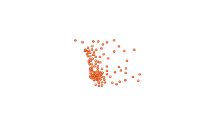

In [18]:
#get feature layer containing updated data for maps associated with the CUMULATIVE COVID-19 dashboard
layer2 = gis.content.get(feature_layer2)
layer2

In [19]:
#List all the current fields in the layer so you can use one as a field template.
cum_covid_lyr = layer2.layers[0]
cum_covid_lyr

<FeatureLayer url:"https://services1.arcgis.com/SIYkiqjmENweC50g/arcgis/rest/services/sd_zip_cumulative_covid_data/FeatureServer/0">

In [20]:
#reformat date for use in appending: append_source = column name in csv, append_field = column name in feature layer, append_alias = column alias
split = most_recent_date.split('/')

append_source = ''

for i in range(len(split)):
    if(split[i][0] is '0'):
        split[i] = split[i][1:]
    if(i == 0):
        append_source += split[i]
    elif(i == (len(split)-1)): 
        append_source += '_' + split[i]
    else:
        append_source += '_' + split[i]

append_field = 'F' + append_source
append_alias = append_source.replace('_','/')

print(append_source, append_field, append_alias)

#Create a dictionary from a deep copy of a field in the feature layer, and update the values of this dictionary to reflect a new field.
new_field = dict(deepcopy(cum_covid_lyr.properties.fields[5]))
new_field['name'] = append_field
new_field['alias'] = append_alias
new_field['length'] = "10"
print(new_field)

#Update feature layer definition with the new field using the add_to_definition() method.
field_list = [new_field]
cum_covid_lyr.manager.add_to_definition({"fields":field_list})

7_13_2021 F7_13_2021 7/13/2021
{'name': 'F7_13_2021', 'type': 'esriFieldTypeDouble', 'actualType': 'float', 'alias': '7/13/2021', 'sqlType': 'sqlTypeFloat', 'nullable': True, 'editable': True, 'domain': None, 'defaultValue': None, 'length': '10'}


{'success': True}

In [21]:
#only need to add index to 'Zipcode' once - cell kept for reference

#Add a unique index to the new attribute field, needed to append
#flds = [f.fields.lower() for f in cum_covid_lyr.properties.indexes if f.isUnique]

#for fld in cum_covid_lyr.properties.fields:
#    if fld.name.lower() in flds:
#        print(f"{fld.name:30}{fld.type:25}isUnique")
#    else:
#        print(f"{fld.name:30}{fld.type:25}")

#Create a copy of one index, then edit it to reflect values for a new index. Then add that to the layer definition.
#name_idx = dict(deepcopy(cum_covid_lyr.properties['indexes'][0]))
#name_idx['name'] = 'Zipcode'
#name_idx['fields'] = 'Zipcode'
#name_idx['isUnique'] = True
#name_idx['description'] = 'index_name'
#name_idx

#index_list = [name_idx]
#cum_covid_lyr.manager.add_to_definition({"indexes":index_list})

#Verify the index was added
#layer2 = gis.content.get(feature_layer2)
#layer2

#flds = [f.fields.lower() for f in cum_covid_lyr.properties.indexes if f.isUnique]

#for fld in cum_covid_lyr.properties.fields:
#    if fld.name.lower() in flds:
#        print(f"{fld.name:30}{fld.type:25}isUnique")
#    else:
#        print(f"{fld.name:30}{fld.type:25}") 

In [22]:
#update csv item to contain new date column for addition to the feature layer
append_df2 = wide[['Zipcode', '{}'.format(most_recent_date)]]
append_df2 = append_df2.rename(columns = {'{}'.format(most_recent_date): '{}'.format(append_source)})

append_df2 = append_df2[append_df2.index.notnull()]
append_df2 = append_df2.fillna(0)
append_df2['{}'.format(append_source)] = append_df2['{}'.format(append_source)].astype(int)
append_df2.to_csv(append_csv_path)

append_csv_item = gis.content.get(append_csv)
#append_csv_item
append_csv_item.update({}, append_csv_path)

#get *append_csv_info* when appending a new column for source_info
append_csv_info = gis.content.analyze(item=append_csv, file_type='csv', location_type='none')

# append_csv_info
#append new date column to feature layer from csv item
cum_covid_lyr.append(item_id= append_csv,
                      upload_format = 'csv',
                      field_mappings = [{"name":"{}".format(append_field), "source":"{}".format(append_source)},
                                        {"name":"Zipcode", "source":"Zipcode"}],
                      source_info = append_csv_info['publishParameters'],
                      update_geometry=False,
                      append_fields=["{}".format(append_field), "Zipcode"],
                      skip_inserts=True,
                      upsert_matching_field="Zipcode")

True

### MODIFY CONFIRMED CASES WEB MAP SYMBOLOGY

In [25]:
#confirmed cases map

#get map data
cc_data = get_map(cc)

#set symbol to new date field, adjust max symbology
cc_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['field'] = append_field
cc_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['field'] = append_field
cc_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['maxDataValue'] = max_confirmed.item()
cc_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['maxSliderValue'] = max_confirmed.item()

#set labeling to new date field
cc_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['labelingInfo'][0]['labelExpressionInfo']['expression'] = '$feature["{}"]'.format(append_field)
cc_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['labelingInfo'][0]['labelExpressionInfo']['value'] = ('{' + append_field + '}')
cc_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['labelingInfo'][0]['fieldInfos'][0]['fieldName'] = append_field

#set filter to new date
cc_data['operationalLayers'][2]['layerDefinition']['definitionExpression'] = ('{} > 0'.format(append_field))

#adjust last date in popup
new_date = cc_data['operationalLayers'][2]['popupInfo']['fieldInfos'][-1].copy()
new_date['fieldName'] = append_field
new_date['label'] = append_alias
cc_data['operationalLayers'][2]['popupInfo']['fieldInfos'][-1]['visible'] = False
cc_data['operationalLayers'][2]['popupInfo']['fieldInfos'].append(new_date)
#cc_data['operationalLayers'][2]['popupInfo']['fieldInfos']

#add new date to popup chart
popup_chart=cc_data['operationalLayers'][2]['popupInfo']['mediaInfos'][0]['value']['fields']
popup_chart.append(append_field)
cc_data['operationalLayers'][2]['popupInfo']['mediaInfos'][0]['value']['fields'] = popup_chart

#update map to save changes
cc_update = update_map(cc, cc_data)
cc_update

<Item title:"SD-COVID-Zipcodes_Main" type:Web Map owner:mtsou_SDSUGeo>


True

# UPDATE 7 DAY DASHBOARD

### OVERWRITE

In [29]:
#get feature layer containing updated data for maps associated with the COVID-19 dashboards
layer = gis.content.get(seven_layer)
layer

layer_collection = FeatureLayerCollection.fromitem(layer)

#call the overwrite() method which can be accessed using the manager property
layer_collection.manager.overwrite(seven_path)

{'success': True}

### MAP SYMBOLOGY

In [30]:
#seven day map

#get map data
sm_data = get_map(seven_map)

#adjust symbology for graduated points to reflect new max/min
#MAX DAILY INCREASE
sm_data['operationalLayers'][4]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['maxSliderValue'] = max_7day.item()
sm_data['operationalLayers'][4]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['maxDataValue'] = max_7day.item()

sm_data['operationalLayers'][5]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['maxSliderValue'] = max_7day.item()
sm_data['operationalLayers'][5]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['maxDataValue'] = max_7day.item()

#update map to save changes
sm_update = update_map(seven_map, sm_data)
sm_update

<Item title:"San Diego Zip Code 7 Day COVID-19 Case Increases" type:Web Map owner:jembury_SDSUGeo>


True

In [31]:
#seven day map mobile

#get map data
smm_data = get_map(seven_map_mobile)

#adjust symbology for graduated points to reflect new max/min
#MAX DAILY INCREASE
smm_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['maxSliderValue'] = max_7day.item()
smm_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['maxDataValue'] = max_7day.item()

smm_data['operationalLayers'][3]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['maxSliderValue'] = max_7day.item()
smm_data['operationalLayers'][3]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['maxDataValue'] = max_7day.item()

#update map to save changes
smm_update = update_map(seven_map_mobile, smm_data)
smm_update

<Item title:"San Diego Zip Code 7 Day COVID-19 Cases - Mobile" type:Web Map owner:jembury_SDSUGeo>


True

# VIEW UPDATED DASHBOARDS

In [32]:
#open cumulative/growth chart map
webbrowser.open(cumulative_dash, new=2)

#open seven day cases dash
webbrowser.open(seven_dash, new=2)

True